In [104]:
# Set algorithm, mode and file name from command line arguments.
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import select
from revolve2.experimentation.database import OpenMethod, open_database_sqlite

In [105]:
# Settings
paths = {"CPPN": "C:\\Users\\niels\\Downloads\\CPPN\\Evolution",
         "GRN": "C:\\Users\\niels\\Downloads\\GRN_runs",
         "GRN_system": "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution",}
column = "y_distance"

In [106]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    print(percentile_.__name__)
    return percentile_

In [107]:
def set_environments(algo, mode):
    # Set environment variables
    file_name = "nan.sqlite"
    assert algo in ["GRN", "GRN_system", "GRN_system_adv", "CPPN"], "ALGORITHM must be either GRN, GRN_system or CPPN"
    assert mode in ["random search", "evolution"], "MODE must be either random search or evolution"
    assert type(file_name) == str, "FILE_NAME must be a string"
    assert file_name.endswith(".sqlite"), "FILE_NAME must end with sqlite"
    os.environ["ALGORITHM"] = algo
    os.environ["MODE"] = mode
    os.environ["DATABASE_FILE"] = file_name

In [108]:
# Columns
columns = ["fitness", "energy_used", 
               
               "x_distance", "tot_xdistance", "xmax", "y_distance", "tot_ydistance",
               
               "min_dx", "dx25", "mean_dx", "median_dx", "dx75", "max_dx", "std_dx",
               
               "min_dy", "dy25", "mean_dy", "median_dy", "dy75", "max_dy", "std_dy",
                
                "energy_used_min", "energy_used_25", "energy_used_mean", "energy_used_median",
                "energy_used_75", "energy_used_max", "energy_used_std",

                "force_std_motor_min", "force_std_motor_25", "force_std_motor_mean", "force_std_motor_median",
                "force_std_motor_75", "force_std_motor_max", "force_std_motor_std",

                "force_std_all_min", "force_std_all_25", "force_std_all_mean", "force_std_all_median",
                "force_std_all_75", "force_std_all_max", "force_std_all_std",

                "efficiency", "efficiency_min", "efficiency_25", "efficiency_mean", "efficiency_median",
                "efficiency_75", "efficiency_max", "efficiency_std",

                "balance"]

In [109]:
def select_data(dbengine, column: str) -> pd.DataFrame:
    """Goal:
        Select the data of the column
    -------------------------------------------------------------
    Input:
        dbengine: ?
        column: The column that needs to be selected
    --------------------------------------------------------------
    Output:
        df: pd.Dataframe"""
    # Load packages
    from experiment import Experiment
    from generation import Generation
    from individual import Individual
    from population import Population
    # Select the data of the column
    df = pd.read_sql(
        select(Experiment.id.label("experiment_id"), Generation.generation_index, getattr(Individual, column),)
        .join_from(Experiment, Generation, Experiment.id == Generation.experiment_id)
        .join_from(Generation, Population, Generation.population_id == Population.id)
        .join_from(Population, Individual, Population.id == Individual.population_id),
        dbengine,
    )

    return df

In [110]:
# Initialize dataframe
df = pd.DataFrame([])
# Experiment id
n_exp = 0

# Loop through files
for algo, folder_path in paths.items():
    set_environments(algo, "evolution")
    for file in os.listdir(folder_path):
        if file.endswith(".sqlite"):
            print(file)
            # Open database
            dbengine = open_database_sqlite(folder_path + "\\" + file, open_method=OpenMethod.OPEN_IF_EXISTS)

            # Get pandas data
            if type(column) == list:
                assert column[0] == "x_distance" and column[1] == "tot_xdistance", "Columns must be x_distance ans y_distance"
                df_sub = select_data(dbengine, column[0])
                df_sub.loc[:, "x_ratio"] = select_data(dbengine, column[1])["tot_xdistance"] - df_sub.loc[:, "x_distance"]
                # Fill inf with 0
                df_sub.replace([np.inf, -np.inf], np.nan, inplace = True)
                df_sub.fillna(0, inplace = True)
                df_sub.drop(columns = ["x_distance"], inplace = True)
            else:
                df_sub = select_data(dbengine, column)

            df_sub["experiment_id"] = ((df_sub["experiment_id"] - df_sub["experiment_id"].min()) + n_exp).astype(int).values
            df_sub["Algorithm"] = algo
            print(df_sub["experiment_id"].unique())
            print(df_sub["experiment_id"].shape)
            n_exp = df_sub["experiment_id"].max() + 1

            # Concat data
            df = pd.concat([df, df_sub], axis = 0)

if type(column) == list:
    column = "x_ratio"


database_CPPN_evo1.sqlite


# Line Plot

In [ ]:
# # Initialize plot
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# # Normalize
# #df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# for iplot, algo in enumerate(["GRN_system", "GRN", "CPPN"]):
#     color = {"GRN": "brown", "GRN_system": "grey", "CPPN": "red"}[algo]	
#     alpha = {"GRN": 0.2, "GRN_system": 0.2, "CPPN": 0.2}[algo]
#     iplot = 0
#     df_sub = df[df["Algorithm"] == algo]
#     # Select even generations
#     first_generation = df_sub.loc[df_sub["generation_index"] == 0, :]
#     df_sub = df_sub.loc[(df_sub.loc[:, "generation_index"] % 2) == 0, :]
#     df_sub = pd.concat([first_generation, df_sub])
#     df_sub["generation_index"] = (df_sub.loc[:, "generation_index"] / 2).astype(int).values

#     # Get max and mean fitness per experiment per generation
#     agg_per_experiment_per_generation = (
#         df_sub.groupby(["experiment_id", "generation_index"])
#         .agg({column: ["max", "median", percentile(0.25), percentile(0.75),
#                        "mean"]})
#         .reset_index()
#     )

#     # Aggregate over experiments
#     agg_per_experiment_per_generation.columns = [
#         "experiment_id",
#         "generation_index",
#         f"max_{column}",
#         f"median_{column}",
#         f"{column}_25",
#         f"{column}_75",
#         f"{column}_mean"
#     ]

#     agg_per_generation = (
#         agg_per_experiment_per_generation.groupby("generation_index")
#         .agg({f"max_{column}": ["median", "std"], f"median_{column}": ["median", "std",
#             percentile(0.25), percentile(0.75)],
#             f"{column}_25": ["median", percentile(0.25), percentile(0.75)], 
#             f"{column}_75": ["median", percentile(0.25), percentile(0.75)],
#             f"{column}_mean": ["mean", "std"]}
#             ).reset_index()
#     )

#     # Set columns
#     agg_per_generation.columns = [
#         "generation_index",
#         f"max_{column}_median",
#         f"max_{column}_std",
#         f"median_{column}_median",
#         f"median_{column}_std", 
#         f"median_{column}_25",
#         f"median_{column}_75",
#         f"{column}_25_median",
#         f"{column}_25_25",
#         f"{column}_25_75",
#         f"{column}_75_median",
#         f"{column}_75_25",
#         f"{column}_75_75",
#         f"mean_{column}_mean",
#         f"mean_{column}_std"
#         ]

#     # # Plot first quartile
#     # ax[iplot, 0].plot(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"{column}_25_median"],
#     #     label=algo,
#     #     color=color,
#     # )
#     # ax[iplot, 0].fill_between(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"{column}_25_25"],
#     #     agg_per_generation[f"{column}_25_75"],
#     #     color=color,
#     #     alpha=0.2,
#     # )

#     # # Plot median
#     # ax[iplot].plot(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"median_{column}_median"],
#     #     label=algo,
#     #     color=color,
#     # )
#     # ax[iplot].fill_between(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"median_{column}_25"],
#     #     agg_per_generation[f"median_{column}_75"],
#     #     color=color,
#     #     alpha=0.2,
#     # )

#     # Plot mean
#     ax.plot(
#         agg_per_generation["generation_index"],
#         agg_per_generation[f"mean_{column}_mean"],
#         label=algo,
#         color=color,
#     )
#     # ax.fill_between(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"mean_{column}_mean"] - agg_per_generation[f"mean_{column}_std"],
#     #     agg_per_generation[f"mean_{column}_mean"] + agg_per_generation[f"mean_{column}_std"],
#     #     color=color,
#     #     alpha=alpha,
#     # )

#     # # Plot third quartile
#     # ax[iplot, 2].plot(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"{column}_75_median"],
#     #     label=algo,
#     #     color=color,
#     # )
#     # ax[iplot, 2].fill_between(
#     #     agg_per_generation["generation_index"],
#     #     agg_per_generation[f"{column}_75_25"],
#     #     agg_per_generation[f"{column}_75_75"],
#     #     color=color,
#     #     alpha=0.2,
#     # )


# #for i in range(0, 1):
# ax.set_xlim(0, 600)
# #ax.set_ylim(0, 1)
# # ax.set_ylim(0, 10.5)
# ax.set_xlabel("Generation Index", fontweight = "bold", size = 40)
# ax.set_ylabel(column.title(), fontweight = "bold", size = 40)
# ax.tick_params(axis = "both", which = "both", labelsize = 20, length=0, pad = 20)
# # Remove spines
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)

# # --- Legend, grid, tight layout
# ax.legend(loc = "lower right", fontsize = 20)

# # Order legend --> also hide box
# handles, labels = ax.get_legend_handles_labels()
# order = [2, 1, 0]
# ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc = "lower right", fontsize = 20,
#           frameon = False)

# ax.grid()
# #ax.set_ylim(0, 1)

# plt.tight_layout()
# plt.show()

# Boxplot

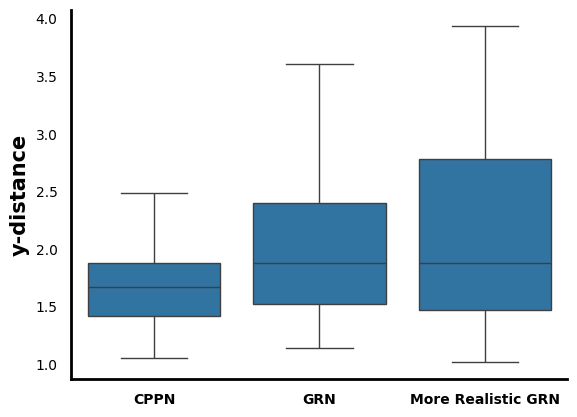

In [ ]:
import seaborn as sns
# Select data
df_sub = df[df["Algorithm"].isin(["CPPN", "GRN", "GRN_system"])]
df_sub = df_sub.loc[df_sub["generation_index"] == 1200, :]
# Aggregate over experiments per algorithm to median
df_sub[column] = abs(df_sub[column])
df_sub = df_sub.groupby(["Algorithm", "experiment_id"]).agg({column: "median"}).reset_index()
df_sub.to_excel("C:\\Users\\niels\\Downloads\\y_distance_data.xlsx")
# Plot
sns.boxplot(x = "Algorithm", y = column, data = df_sub)
# Set labels
plt.xlabel("", fontweight = "bold", size = 15)
#plt.ylabel(column.title(), fontweight = "bold", size = 15)
plt.ylabel("y-distance", fontweight = "bold", size = 15)
# Increase spine thickness
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["bottom"].set_linewidth(2)

# Set xtick labels
plt.xticks([0, 1, 2], ["CPPN", "GRN", "More Realistic GRN"], fontweight = "bold")
# Remove ticks
plt.tick_params(axis = "both", which = "both", length = 0)
# Remove top and right spine
sns.despine()
# Increase padding of tick labels
plt.tick_params(axis = "both", which = "both", pad = 10)
# Set ylim
#plt.ylim(2, 14)
#plt.ylim(0.01, 0.06)
#plt.ylim(-0.1, 2)

plt.show()


In [ ]:
# from copy import deepcopy
# x_distance = deepcopy(df)

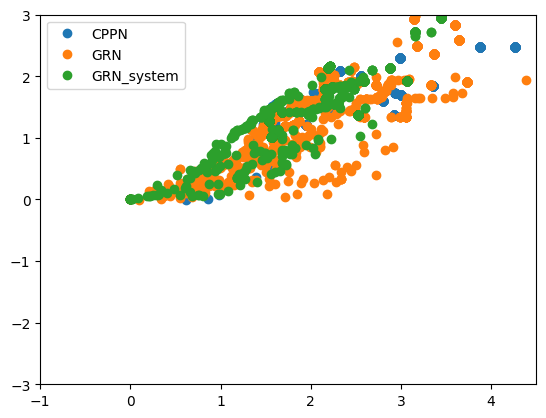

In [ ]:
for algo in ["CPPN", "GRN", "GRN_system"]:
    data = x_distance.loc[x_distance["generation_index"] == 1200, :]
    data = data.loc[data["Algorithm"] == algo]
    data2 = df.loc[df["generation_index"] == 1200, :]
    data2 = data2.loc[data2["Algorithm"] == algo]

    plt.plot(data["tot_xdistance"], data2["x_distance"], "o", label = algo)
    plt.xlim(-1, 4.5)
    plt.ylim(-3, 3)

plt.legend()
plt.show()